### Setup

In [3]:
!pip install tensorflow

In [4]:
import tensorflow as tf

In [5]:
tf.__version__

'2.3.0'

In [6]:
# To generate GIFs
!pip install gitpython
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 163kB 7.6MB/s 
     |████████████████████████████████| 71kB 5.8MB/s 


In [7]:
!pip install matplotlib
!pip install numpy

import imageio
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from IPython import display
import time
import os

In [8]:
import tqdm.notebook as tq
from os import listdir
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.image as mpimg

In [9]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

from PIL import Image
print(Image.__file__)

import Image
print(Image.__file__)

import PIL

!pip install sklearn
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.6/dist-packages/PIL/Image.py
/usr/local/lib/python3.6/dist-packages/PIL/Image.py


### Load and prepare the dataset

In [10]:
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
from tensorflow.keras.models import Sequential

In [11]:
#--some helpful stuff for loading images, img->array, rgb->grayscale
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [12]:
#--loading images
trainfolder='/content/drive/MyDrive/Colab Notebooks/ENGS108/roads_only/roads_only/'

# size=(128,128) <-- google earth images gan
size=(256,256)
#size = (512, 512)

trainimages=list()
for filename in listdir(trainfolder):
      # load and resize the image
      pixels = load_img(trainfolder + filename, color_mode="grayscale", target_size=size) #color_mode="grayscale" before taget_size
      # convert to numpy array
      pixels = img_to_array(pixels)
      # Normalize the images to [-1, 1]
      pixels=(pixels- 127.5) / 127.5
      # store
      trainimages.append(pixels)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# from matplotlib import pyplot
# #--plot images
# n_samples = 3
# for i in range(n_samples):
#     pyplot.subplot(2, n_samples, 1 + i)
#     pyplot.axis('off')
#     pyplot.imshow(trainimages[i].astype('uint8'))

In [16]:
BUFFER_SIZE = 300 #from 300; 500; 400
BATCH_SIZE = 40 #from 30 -> checkers; 50 -> ran course entirely, looked bad; 40: stopped midexecutio (~200+) - similar to batch of 50 -> back to 40

In [17]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(trainimages).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [18]:
len(train_dataset)

8

len(train_dataset)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

In [94]:
# output image: 16x16 => 64x64 => 128x128 => 256x256 (final output image is 256x256x1)

def make_generator_model():   
    model = tf.keras.Sequential()
    #model.add(layers.Dense(128*128*512, use_bias=False, input_shape=(100,)))
    # model.add(layers.Dense(64*64*512, use_bias=False, input_shape=(100,)))
    # model.add(layers.Dense(32*32*512, use_bias=False, input_shape=(100,)))
    model.add(layers.Dense(16*16*256, use_bias=False, input_shape=(100,)))
    #model.add(layers.Dense(16*16*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((16, 16, 256)))
    assert model.output_shape == (None, 16, 16, 256)   # Note: None is the batch size

    #filter size:(3,3)
    #CHANGED FILTER SIZE TO (2,2) FROM (3,3)
    #Fileter size back to (3,3)
    #filter size (4,4)
    #filter size (5,5)
    model.add(layers.Conv2DTranspose(256, (4,4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #ADDED FOR 512X512 trial starting at 32
    # model.add(layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 64, 64, 256)
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #ADDED FOR 512X512 starting at 64
    # model.add(layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 128, 128, 128)
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())

    # added a new layer as opposed to google earth gan
    model.add(layers.Conv2DTranspose(64, (4,4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 256, 256, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # #ADDED FOR 512X512 starting at 128x128
    # model.add(layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 256, 256, 128)
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())

    # # new layer to upscale to 512x512
    # model.add(layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 512, 512, 64)
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())

    #Changed from (4,4) in google earth gan to (2,2)
    # CHANGED FROM (2,2) TO (3,3)
    #back to (4,4)
    model.add(layers.Conv2DTranspose(1, (3,3), padding='same', use_bias=False, activation='tanh')) #originally also had strides; 1 because it's greyscale; 3 for color
    assert model.output_shape == (None, 256, 256, 1)

    return model

Use the (as yet untrained) generator to create an image.

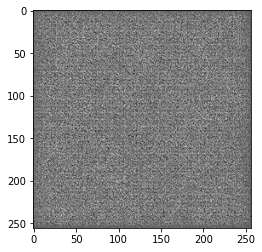

In [95]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [96]:
# CHANGED FILTER SIZE TO (2,2) FROM (3,3)
#generator filter (5,5) -> changed discrim filter to (4,4)
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3,3), strides=(2, 2), padding='same',
                                     input_shape=[256, 256, 1])) 
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3,3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [97]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00013945]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [98]:
# This method returns a helper function to compute cross entropy loss: if we choose to use binary cross entropy; currently using mse
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [99]:
def discriminator_loss(real_output, fake_output):
    #real_loss = tf.keras.losses.mse(tf.ones_like(real_output), real_output)
    #fake_loss = tf.keras.losses.mse(tf.zeros_like(fake_output), fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  ##if using binary crossentropy
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  ##if using binary crossentropy
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [100]:
def generator_loss(fake_output):
    #return tf.keras.losses.mse(tf.ones_like(fake_output), fake_output)
    generator_loss = cross_entropy(tf.ones_like(fake_output), fake_output)  ## if using binary crossentropy
    return generator_loss


The discriminator and the generator optimizers are different since we will train two networks separately.

In [101]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [102]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [103]:
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [104]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [105]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)
            
        # Produce an image for every 5'th epoch to showcase progress
        if (epoch + 1) % 5 == 0:
          display.clear_output(wait=True)
          generate_images(generator, epoch + 1, seed)

        # Save the model every 30 epochs
        if (epoch + 1) % 30 == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)

        # Print time for each epoch
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [107]:
def generate_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
     
    fig=plt.figure(figsize=(6, 6))
    plt.imshow(np.reshape((0.5 * generator.predict(np.random.normal(0,1,(1,100))) + 0.5), (256, 256))*127.5+127.5, cmap='gray')
    plt.axis('off')

    plt.show()

## Train the model


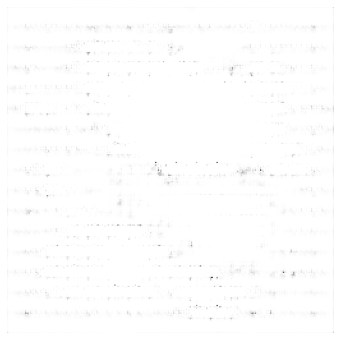

In [108]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [109]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

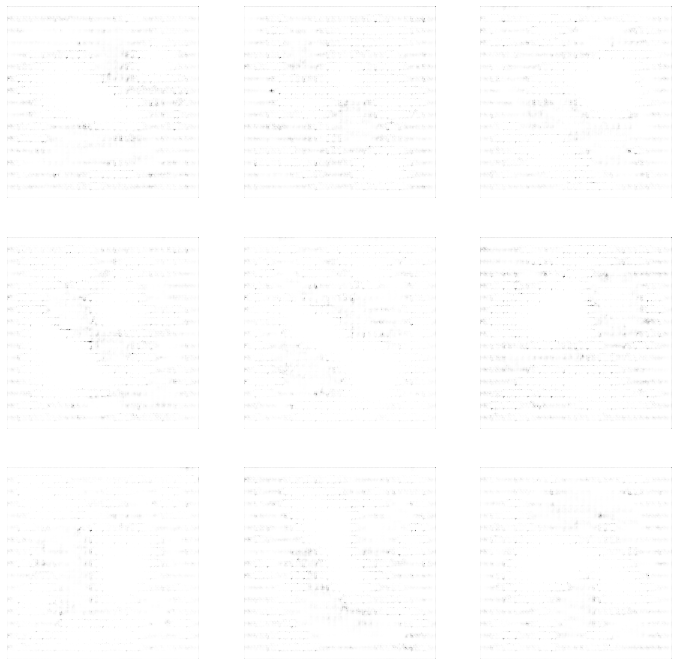

In [111]:
fig=plt.figure(figsize=(12, 12))
for i in range(9):
  plt.subplot(3, 3, i+1) 
  plt.imshow(np.reshape((0.5 * generator.predict(np.random.normal(0,1,(1,100))) + 0.5), (256, 256)), cmap='gray')
  plt.axis('off')